In [ ]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer,\
                                            TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,\
                            log_loss
from sklearn.dummy import DummyClassifier
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,\
                             VotingClassifier
from mlxtend.classifier import StackingClassifier

In [ ]:
# defining required functions

from spacy.lang.en.stop_words import STOP_WORDS

def text_preprocessing(dataset, text, index, column):
    
    '''This function preprocesses the text'''
    
    if type(text) is not int:
        string = ''
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        text = re.sub('\s+',' ', text)
        text = text.lower()        
        for word in text.split():
            if word not in STOP_WORDS:
                string += word + ' '        
        dataset.loc[index,column] = string

from sklearn.metrics import confusion_matrix

def plot_matrix(y_test, y_pred):
    
    '''This function plots confusion, precision and recall matrices'''
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    # C - confusion matrix
    C = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".0f", xticklabels=labels,\
                yticklabels=labels)
    plt.xlabel('Predicted Class', fontsize = 14)
    plt.ylabel('Original Class', fontsize = 14)
    plt.title('Confusion Matrix',fontsize = 22)
    plt.show()
    
    # P - precision matrix
    P =(C/C.sum(axis=0))
    plt.figure(figsize=(20,7))
    sns.heatmap(P, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels,\
                yticklabels=labels)
    plt.xlabel('Predicted Class', fontsize = 14)
    plt.ylabel('Original Class', fontsize = 14)
    plt.title('Precision Matrix', fontsize = 22)
    plt.show()
    
    # R - recall matrix
    R =(((C.T)/(C.sum(axis=1))).T)
    plt.figure(figsize=(20,7))
    sns.heatmap(R, annot=True,cmap="YlGnBu", fmt=".3f", xticklabels=labels,\
                yticklabels=labels)
    plt.xlabel('Predicted Class', fontsize = 14)
    plt.ylabel('Original Class', fontsize = 14)
    plt.title('Recall Matrix', fontsize = 22)
    plt.show()
    
    return


def intersec_text(X_1, X_2, col):
    
    '''This function returns percentage of X_1[col] data in X_2[col]'''
    
    count_vect_1 = CountVectorizer()
    count_vect_2 = CountVectorizer()
    X_1_trans = count_vect_1.fit_transform(X_1[col])
    X_2_trans = count_vect_2.fit_transform(X_2[col])
    fea_1 = count_vect_1.get_feature_names()
    fea_2 = count_vect_2.get_feature_names()

    len1 = len(set(fea_2))
    len2 = len(set(fea_1) & set(fea_2))
    
    return round(len2*100/len1,3)

def imp_features(indices,no_features,gene,var,text):
    
    no_words = 0   
    fea1_len = X_train_gene.shape[1]
    fea2_len = X_train_var.shape[1]
    
    for num,i in enumerate(indices):
        if i < fea1_len:
            word = count_vect_gene.get_feature_names()[i]
            if word == gene:
                print("{}) Gene '{}' is present in query point".format(num,word))
                no_words += 1
                
        elif i < (fea1_len + fea2_len):
            word = count_vect_var.get_feature_names()[i-fea1_len]
            if word == var:
                print("{}) Variation '{}' is present in query point".\
                      format(num,word))
                no_words += 1
        
        else:
            word = tfidf_vect.get_feature_names()[i- (fea1_len + fea2_len)]
            if word in text.split():
                print("{}) Text '{}' is present in query point".format(num,word))
                no_words += 1
    
    print('Out of top {} important features, {} are present in query point'.\
          format(no_features,no_words))
    
    return

In [ ]:
dataset = pd.read_csv('dataset')

In [ ]:
# first five columns of dataset
dataset.head()

,ID,Gene,Variation,Text,Class
0,0,FAM58A,Truncating Mutations,cyclin dependent kinase cdks regulate variety ...,1
1,1,CBL,W802*,abstract background non small cell lung cancer...,2
2,2,CBL,Q249E,abstract background non small cell lung cancer...,2
3,3,CBL,N454D,recent evidence demonstrate acquire uniparenta...,3
4,4,CBL,L399V,oncogenic mutation monomeric casitas b lineage...,4


In [ ]:
dataset.shape

(3321, 5)

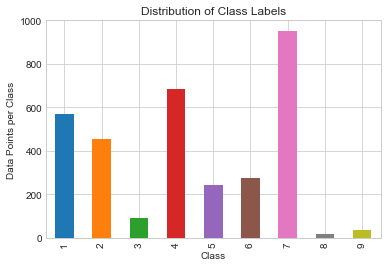

No. of data points in class 7 : 953 (28.696)
No. of data points in class 4 : 686 (20.656)
No. of data points in class 1 : 568 (17.103)
No. of data points in class 2 : 452 (13.61)
No. of data points in class 6 : 275 (8.281)
No. of data points in class 5 : 242 (7.287)
No. of data points in class 3 : 89 (2.68)
No. of data points in class 9 : 37 (1.114)
No. of data points in class 8 : 19 (0.572)


In [ ]:
class_label_dist = dataset['Class'].value_counts().sort_index()

sns.set_style('whitegrid')
class_label_dist.plot('bar')
plt.xlabel('Class')
plt.ylabel('Data Points per Class')
plt.title('Distribution of Class Labels')
plt.show()

sorted_labels = dataset['Class'].value_counts()

for i in sorted_labels.index:
    print('No. of data points in class {} : {} ({})'\
          .format(i, sorted_labels[i],round(sorted_labels[i]*100/dataset.shape[0],3)))

## Text Preprocessing

In [ ]:
# checking for nan
dataset[dataset.isnull().any(axis = 1)]

,ID,Gene,Variation,Text,Class
1109,1109,FANCA,S1088F,NaN,1
1277,1277,ARID5B,Truncating Mutations,NaN,1
1407,1407,FGFR3,K508M,NaN,6
1639,1639,FLT1,Amplification,NaN,6
2755,2755,BRAF,G596C,NaN,7


In [ ]:
# replacing nan in Text field with gene and variation features
dataset.loc[dataset['Text'].isnull(),'Text'] = dataset['Gene'] +' '+\
            dataset['Variation']

In [ ]:
# replacing multiple spaces with _ in Gene and Variation features 
# so as to consider them as single string
dataset['Gene'] = dataset['Gene'].str.replace('\s+','_')
dataset['Variation'] = dataset['Variation'].str.replace('\s+','_')

In [ ]:
for index, column in dataset.iterrows():
    if type(column['Text']) is str:
        text_preprocessing(dataset,column['Text'], index, 'Text')

## Splitting the dataset into train and test sets

In [ ]:
# splitting the data into train,cross validation and test sets
train_df,X_test_df,y_train,y_test=train_test_split(dataset.iloc[:,1:4],\
                                                   dataset.iloc[:,4],\
                                                   test_size = 0.2, \
                                                   stratify = dataset.iloc[:,4])
X_train_df, X_cv_df, y_train, y_cv = train_test_split(train_df, y_train,\
                                                    test_size = 0.2,\
                                                      stratify = y_train)

## Featurization of data using one hot encoding

In [ ]:
count_vect_gene = CountVectorizer()
count_vect_var = CountVectorizer()
tfidf_vect = TfidfVectorizer(min_df = 3)

X_train_gene = normalize(count_vect_gene.fit_transform(X_train_df['Gene']),axis = 0)
X_train_var = normalize(count_vect_var.fit_transform(X_train_df['Variation'].values),\
                        axis = 0)
X_train_text = normalize(tfidf_vect.fit_transform(X_train_df['Text'].values),axis = 0)

X_train = hstack([X_train_gene, X_train_var, X_train_text])

In [ ]:
X_cv_gene = normalize(count_vect_gene.transform(X_cv_df['Gene']),axis = 0)
X_cv_var = normalize(count_vect_var.transform(X_cv_df['Variation'].values),axis = 0)
X_cv_text = normalize(tfidf_vect.transform(X_cv_df['Text'].values),axis = 0)

X_cv = hstack([X_cv_gene, X_cv_var, X_cv_text])

In [ ]:
X_test_gene = normalize(count_vect_gene.transform(X_test_df['Gene']),axis = 0)
X_test_var = normalize(count_vect_var.transform(X_test_df['Variation'].values),\
                       axis = 0)
X_test_text = normalize(tfidf_vect.transform(X_test_df['Text'].values),axis = 0)

X_test = hstack([X_test_gene, X_test_var, X_test_text])

## Random Model based on train class probabilities

In [ ]:
dummy_clf = DummyClassifier('uniform')
dummy_clf.fit(X_train, y_train)
y_pred_train = dummy_clf.predict(X_train)
y_pred_cv = dummy_clf.predict(X_cv)
y_pred_test = dummy_clf.predict(X_test)

loss = [log_loss(y_train,dummy_clf.predict_proba(X_train)),\
        log_loss(y_cv,dummy_clf.predict_proba(X_cv)),\
        log_loss(y_test,dummy_clf.predict_proba(X_test))]

pd.DataFrame({'Set':['Train','Cross Validation','Test'],'Log Loss': loss} ,\
              index = range(1,4))

,Set,Log Loss
1,Train,2.197225
2,Cross Validation,2.197225
3,Test,2.197225


For Test Set


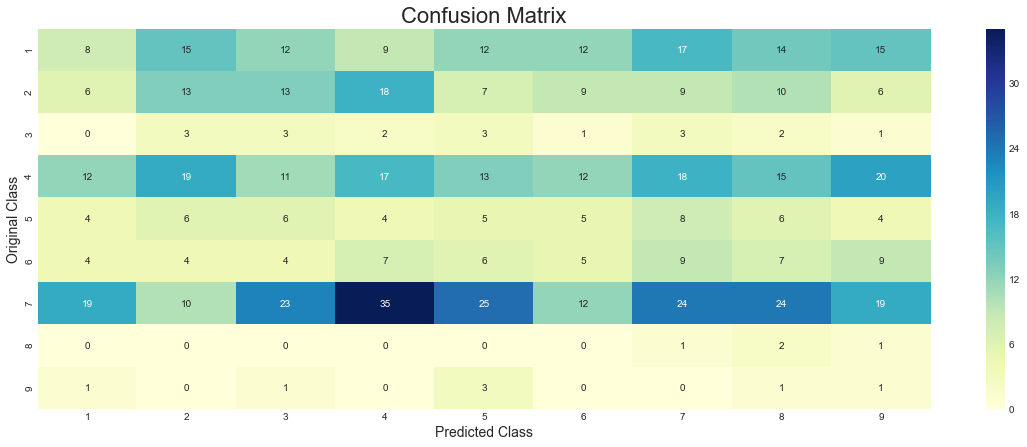

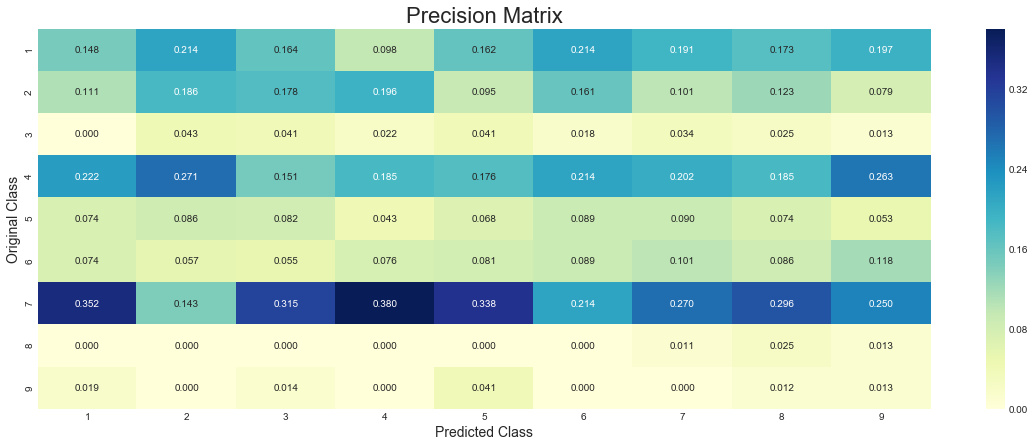

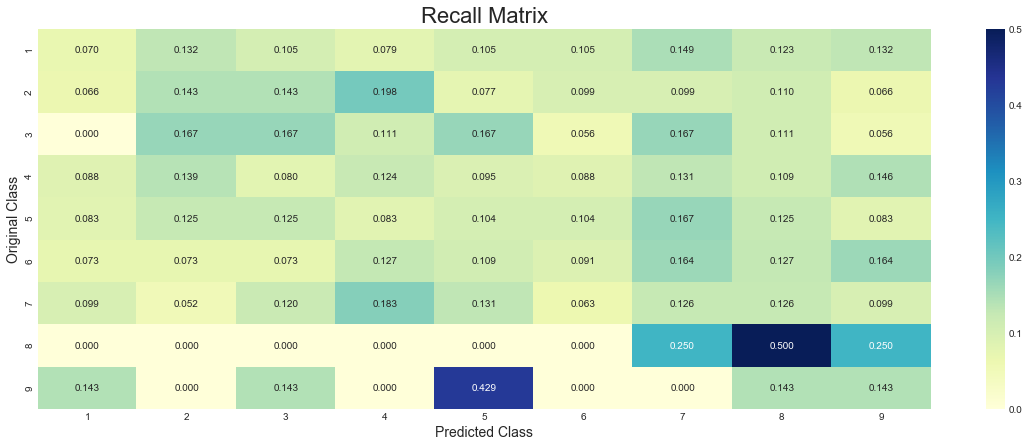

In [ ]:
print('For Test Set')
plot_matrix(y_test,y_pred_test)

# Univariate Analysis

## Gene Feature

In [ ]:
unique_genes = X_train_df['Gene'].value_counts()
print('No. of unique genes :',unique_genes.shape[0])
print('The ten genes that occured more frequently are')
print(unique_genes.head(10))

No. of unique genes : 237
The ten genes that occured more frequently are
BRCA1     165
TP53       98
EGFR       94
PTEN       82
BRCA2      74
BRAF       64
KIT        58
ALK        51
ERBB2      48
PIK3CA     40
Name: Gene, dtype: int64


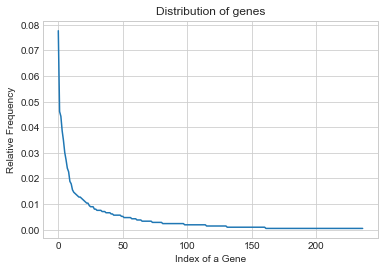

In [ ]:
h = unique_genes.values/sum(unique_genes.values)
plt.plot(h)
plt.xlabel('Index of a Gene')
plt.ylabel('Relative Frequency')
plt.title('Distribution of genes')
plt.show()

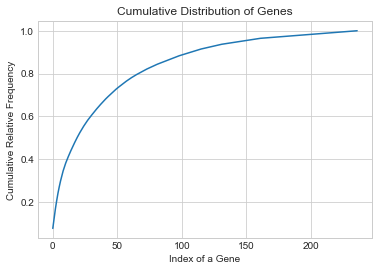

In [ ]:
plt.plot(np.cumsum(h))
plt.xlabel('Index of a Gene')
plt.ylabel('Cumulative Relative Frequency')
plt.title('Cumulative Distribution of Genes')
plt.show()

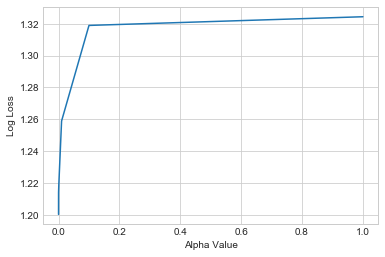

For alpha = 1e-05, the log losses for various sets are


,Set,Log Loss
1,Train,0.989626
2,Cross Validation,1.199866
3,Test,1.221827


In [ ]:
alpha = [10**i for i in range(-5,1)]
cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(loss = 'log', alpha = i, max_iter = 20, random_state = 0)
    clf.fit(X_train_gene,y_train)
    sig_clf = CalibratedClassifierCV(clf,'sigmoid')
    sig_clf.fit(X_train_gene, y_train)
    y_pred_gene = sig_clf.predict_proba(X_cv_gene)
    cv_log_loss.append(log_loss(y_cv, y_pred_gene))

plt.plot(alpha, cv_log_loss)
plt.xlabel('Alpha Value')
plt.ylabel('Log Loss')
plt.show()

best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss = 'log', alpha = best_alpha, max_iter = 100,random_state=0)
clf.fit(X_train_gene, y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(X_train_gene, y_train)

loss = [log_loss(y_train,sig_clf.predict_proba(X_train_gene)),\
        log_loss(y_cv,sig_clf.predict_proba(X_cv_gene)),\
        log_loss(y_test,sig_clf.predict_proba(X_test_gene))]

print('For alpha = {}, the log losses for various sets are'.format(best_alpha))
pd.DataFrame({'Set':['Train','Cross Validation','Test'],'Log Loss': loss} , \
              index = range(1,4))

In [ ]:
print('{} % of cross validation gene data is present in train set'.\
      format(intersec_text(X_cv_df, X_train_df, 'Gene')))
print('{} % of test gene data is present in train set'.\
      format(intersec_text(X_test_df, X_train_df, 'Gene')))

53.814 % of cross validation gene data is present in train set
57.203 % of test gene data is present in train set


## Variation Feature

In [ ]:
unique_vars = X_train_df['Variation'].value_counts()
print('No. of unique variations :',unique_vars.shape[0])
print('The ten variations that occured more frequently are')
print(unique_vars.head(10))

No. of unique variations : 1932
The ten variations that occured more frequently are
Truncating_Mutations    55
Amplification           50
Deletion                47
Fusions                 21
Overexpression           5
G12C                     2
G13C                     2
R170W                    2
T286A                    2
G12V                     2
Name: Variation, dtype: int64


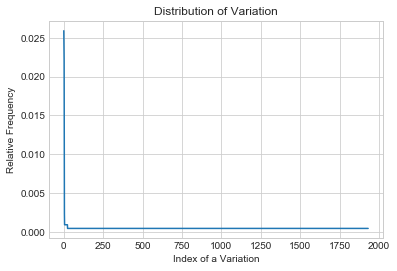

In [ ]:
h = unique_vars.values/sum(unique_vars.values)
plt.plot(h)
plt.xlabel('Index of a Variation')
plt.ylabel('Relative Frequency')
plt.title('Distribution of Variation')
plt.show()

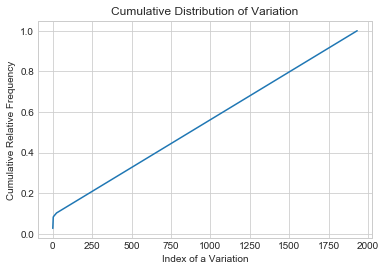

In [ ]:
plt.plot(np.cumsum(h))
plt.xlabel('Index of a Variation')
plt.ylabel('Cumulative Relative Frequency')
plt.title('Cumulative Distribution of Variation')
plt.show()

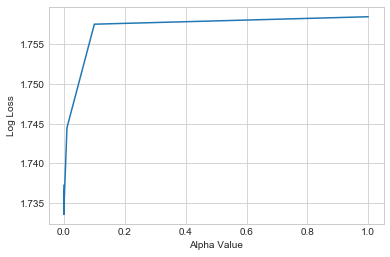

For alpha = 0.0001, the log losses for various sets are


,Set,Log Loss
1,Train,0.551195
2,Cross Validation,1.733775
3,Test,1.687911


In [ ]:
alpha = [10**i for i in range(-5,1)]
cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(loss = 'log', alpha = i, max_iter = 20, random_state = 0)
    clf.fit(X_train_var,y_train)
    sig_clf = CalibratedClassifierCV(clf,'sigmoid')
    sig_clf.fit(X_train_var, y_train)
    y_pred_var = sig_clf.predict_proba(X_cv_var)
    cv_log_loss.append(log_loss(y_cv, y_pred_var))

plt.plot(alpha, cv_log_loss)
plt.xlabel('Alpha Value')
plt.ylabel('Log Loss')
plt.show()

best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss = 'log', alpha = best_alpha, max_iter = 100, \
                    random_state = 0)
clf.fit(X_train_var, y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(X_train_var, y_train)

loss = [log_loss(y_train,sig_clf.predict_proba(X_train_var)),\
        log_loss(y_cv,sig_clf.predict_proba(X_cv_var)),\
        log_loss(y_test,sig_clf.predict_proba(X_test_var))]

print('For alpha = {}, the log losses for various sets are'.format(best_alpha))
pd.DataFrame({'Set':['Train','Cross Validation','Test'],'Log Loss': loss} ,\
             index = range(1,4))

In [ ]:
print('{} % of cross validation variation data is present in train set'.\
      format(intersec_text(X_cv_df, X_train_df, 'Variation')))
print('{} % of test variation data is present in train set'.\
      format(intersec_text(X_test_df, X_train_df, 'Variation')))

1.987 % of cross validation variation data is present in train set
1.681 % of test variation data is present in train set


## Text Feature

In [ ]:
print("No. of unique words :", X_train_text.shape[1])
string = ' '.join(X_train_df['Text'].values)
word_freq = Counter(string.split())
i = 0
print('The ten words that occur more frequently are')
for key, value in sorted(word_freq.items(), key = lambda x: x[1], reverse = True):
    if i == 10: break
    print(key,':',value)
    i += 1

No. of unique words : 32389
The ten words that occur more frequently are
mutation : 210566
cell : 197807
tumor : 78505
protein : 78087
mutant : 77792
cancer : 75071
use : 70306
1 : 67874
patient : 67061
et : 66855


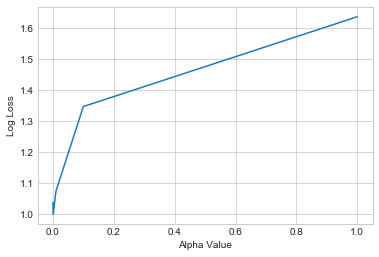

For alpha = 0.001, the log losses for various sets are


,Set,Log Loss
1,Train,0.628463
2,Cross Validation,0.989772
3,Test,1.060085


In [ ]:
alpha = [10**i for i in range(-4,1)]
cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(loss = 'log', alpha = i, max_iter = 20, random_state = 0)
    clf.fit(X_train_text,y_train)
    sig_clf = CalibratedClassifierCV(clf,'sigmoid')
    sig_clf.fit(X_train_text, y_train)
    y_pred_text = sig_clf.predict_proba(X_cv_text)
    cv_log_loss.append(log_loss(y_cv, y_pred_text))

plt.plot(alpha, cv_log_loss)
plt.xlabel('Alpha Value')
plt.ylabel('Log Loss')
plt.show()

best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss = 'log', alpha = best_alpha, max_iter = 100, \
                    random_state = 0)
clf.fit(X_train_text, y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(X_train_text, y_train)

loss = [log_loss(y_train,sig_clf.predict_proba(X_train_text)),\
        log_loss(y_cv,sig_clf.predict_proba(X_cv_text)),\
        log_loss(y_test,sig_clf.predict_proba(X_test_text))]

print('For alpha = {}, the log losses for various sets are'.format(best_alpha))
pd.DataFrame({'Set':['Train','Cross Validation','Test'],'Log Loss': loss} , \
             index = range(1,4))

In [ ]:
print('{} % of cross validation text data is present in train data'.\
      format(intersec_text(X_cv_df, X_train_df,'Text')))
print('{} % of test text data is present in train data'.\
      format(intersec_text(X_test_df, X_train_df, 'Text')))

45.893 % of cross validation text data is present in train data
51.522 % of test text data is present in train data


# Machine Learning Models

## Naive Bayes

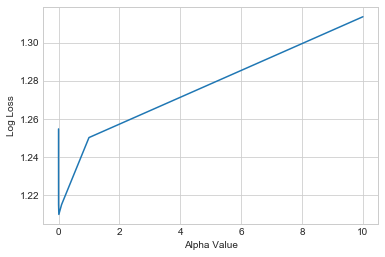

For alpha = 0.01, the log losses for various sets are


,Set,Log Loss
1,Train,0.876146
2,Cross Validation,1.209692
3,Test,1.237686


In [ ]:
alpha = [10**i for i in range(-5,2)]
cv_log_loss = []
for i in alpha:
    clf = MultinomialNB(alpha = i)
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf,'sigmoid')
    sig_clf.fit(X_train, y_train)
    y_pred = sig_clf.predict_proba(X_cv)
    cv_log_loss.append(log_loss(y_cv, y_pred))

plt.plot(alpha, cv_log_loss)
plt.xlabel('Alpha Value')
plt.ylabel('Log Loss')
plt.show()

best_alpha = alpha[np.argmin(cv_log_loss)]
clf_nb = MultinomialNB(alpha = best_alpha)
clf_nb.fit(X_train, y_train)
y_pred = clf_nb.predict(X_test)
sig_clf_nb = CalibratedClassifierCV(clf_nb, method = 'sigmoid')
sig_clf_nb.fit(X_train, y_train)

loss_nb = [log_loss(y_train,sig_clf_nb.predict_proba(X_train)),\
           log_loss(y_cv,sig_clf_nb.predict_proba(X_cv)),\
           log_loss(y_test,sig_clf_nb.predict_proba(X_test))]

print('For alpha = {}, the log losses for various sets are'.format(best_alpha))
pd.DataFrame({'Set':['Train','Cross Validation','Test'],'Log Loss': loss_nb} , \
             index = range(1,4))

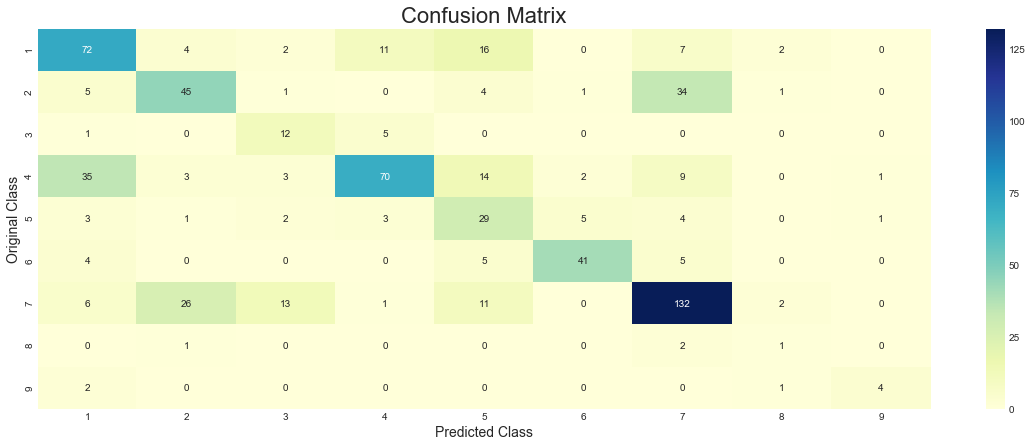

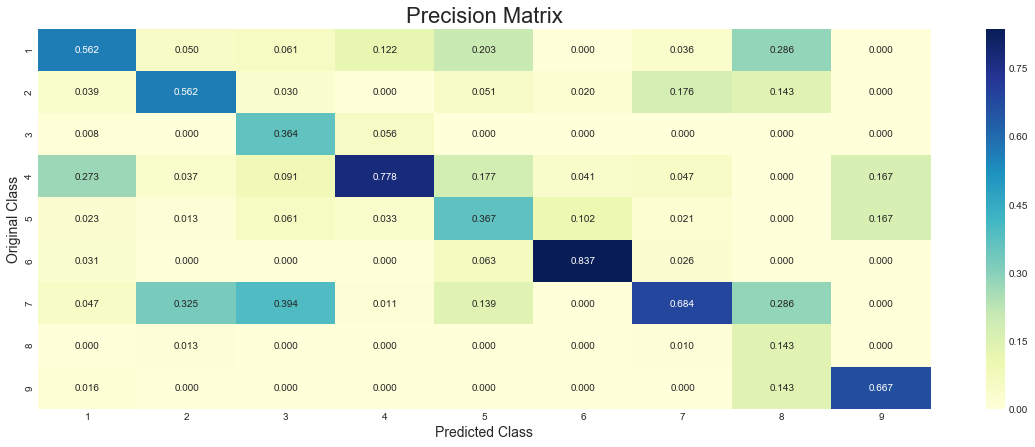

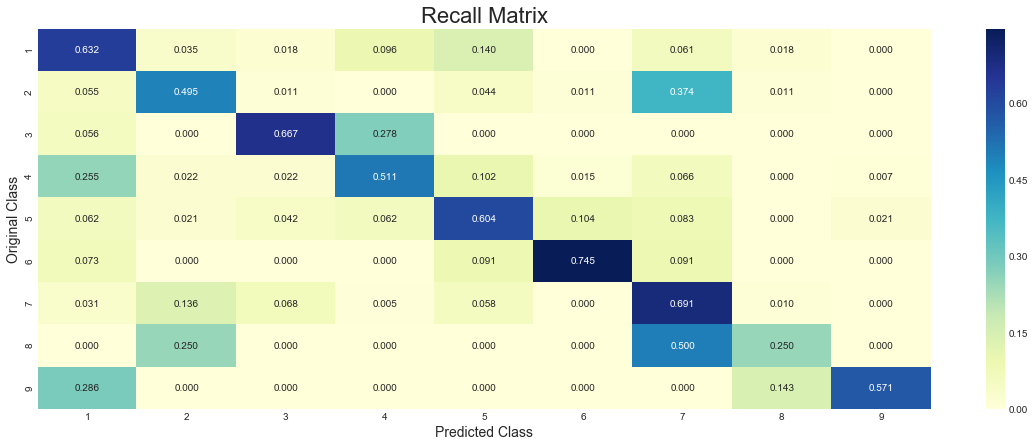

In [ ]:
plot_matrix(y_test, y_pred)

### Correctly Classified Point

In [ ]:
test_point_index = 0
no_features = 100
pred_cls = y_pred[test_point_index]
print('Predicted Class :', pred_cls)
print('Predicted Class Probabilities:',\
      np.round(sig_clf_nb.predict_proba(X_test[test_point_index]),4))
print('Actual Class :', y_test.iloc[test_point_index])
indices = np.argsort(-clf_nb.coef_[pred_cls-1])[:no_features]
print('-'*50)
imp_features(indices, no_features,\
     X_test_df['Gene'].iloc[test_point_index],\
     X_test_df['Variation'].iloc[test_point_index],\
     X_test_df['Text'].iloc[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[0.4175 0.0867 0.0123 0.1144 0.0394 0.1919 0.1302 0.0028 0.0047]]
Actual Class : 1
--------------------------------------------------
0) Text 'type' is present in query point
1) Text 'protein' is present in query point
2) Text 'result' is present in query point
3) Text 'function' is present in query point
4) Text 'indicate' is present in query point
5) Text 'wild' is present in query point
6) Text 'contain' is present in query point
7) Text 'affect' is present in query point
9) Text 'table' is present in query point
10) Text 'dna' is present in query point
11) Text 'region' is present in query point
12) Text 'role' is present in query point
13) Text 'remain' is present in query point
14) Text 'gene' is present in query point
15) Text 'sequence' is present in query point
16) Text 'use' is present in query point
17) Text 'involve' is present in query point
18) Text 'determine' is present in query point
19) Text 'suggest' is present in q

### Misclassified Point

In [ ]:
test_point_index = 2
no_features = 100
pred_cls = y_pred[test_point_index]
print('Class Probabilities: {}'.format(np.round(sig_clf_nb.predict_proba(X_test[test_point_index]),4)))
print('Predicted Class : {}'.format(pred_cls))
print('Actual Class :', y_test.iloc[test_point_index])
indices = np.argsort(-clf.coef_[pred_cls-1])[:no_features]
imp_features(indices, no_features,\
     X_test_df['Gene'].iloc[test_point_index],\
     X_test_df['Variation'].iloc[test_point_index],\
     X_test_df['Text'].iloc[test_point_index])

Class Probabilities: [[0.1147 0.103  0.0144 0.137  0.418  0.047  0.157  0.0034 0.0055]]
Predicted Class : 5
Actual Class : 4
0) Text 'assay' is present in query point
1) Text 'functional' is present in query point
2) Text 'large' is present in query point
3) Text 'variant' is present in query point
4) Text 'base' is present in query point
5) Text 'neutral' is present in query point
7) Text 'datum' is present in query point
8) Text 'assess' is present in query point
9) Text 'allow' is present in query point
10) Text 'introduction' is present in query point
11) Text 'use' is present in query point
12) Text 'align' is present in query point
13) Text 'effort' is present in query point
14) Text 'intermediate' is present in query point
15) Text 'aacr' is present in query point
16) Text 'result' is present in query point
17) Text 'likely' is present in query point
18) Text 'method' is present in query point
19) Text 'information' is present in query point
20) Text 'effect' is present in query

## Logistic Regression

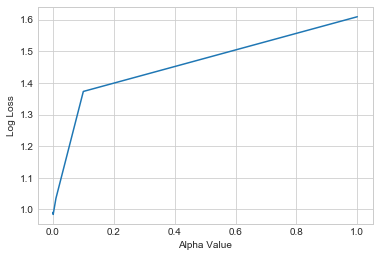

In [ ]:
alpha = [10**i for i in range(-4,1)]
cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(alpha = i, class_weight = 'balanced', loss = 'log', \
                        max_iter = 20)
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf,'sigmoid')
    sig_clf.fit(X_train, y_train)
    y_pred = sig_clf.predict_proba(X_cv)
    cv_log_loss.append(log_loss(y_cv, y_pred))

plt.plot(alpha, cv_log_loss)
plt.xlabel('Alpha Value')
plt.ylabel('Log Loss')
plt.show()

In [ ]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf_lr = SGDClassifier(alpha = best_alpha, class_weight = 'balanced', loss = 'log', \
                       max_iter = 100)
clf_lr.fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)
sig_clf_lr = CalibratedClassifierCV(clf_lr, method = 'sigmoid')
sig_clf_lr.fit(X_train, y_train)

loss_lr = [log_loss(y_train,sig_clf_lr.predict_proba(X_train)),\
        log_loss(y_cv,sig_clf_lr.predict_proba(X_cv)),\
        log_loss(y_test,sig_clf_lr.predict_proba(X_test))]

print('For alpha = {}, the log losses for various sets are'.format(best_alpha))
pd.DataFrame({'Set':['Train','Cross Validation','Test'],'Log Loss': loss_lr} , \
             index = range(1,4))

For alpha = 0.001, the log losses for various sets are


,Set,Log Loss
1,Train,0.574532
2,Cross Validation,0.979364
3,Test,1.049650


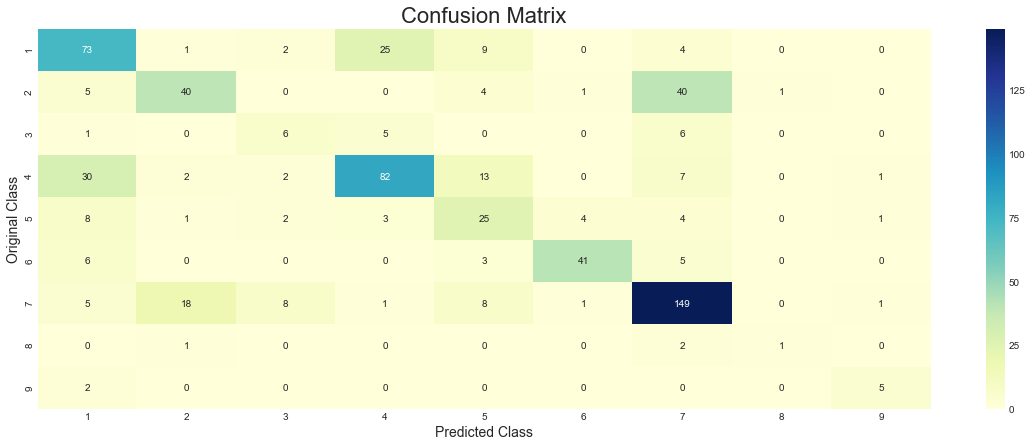

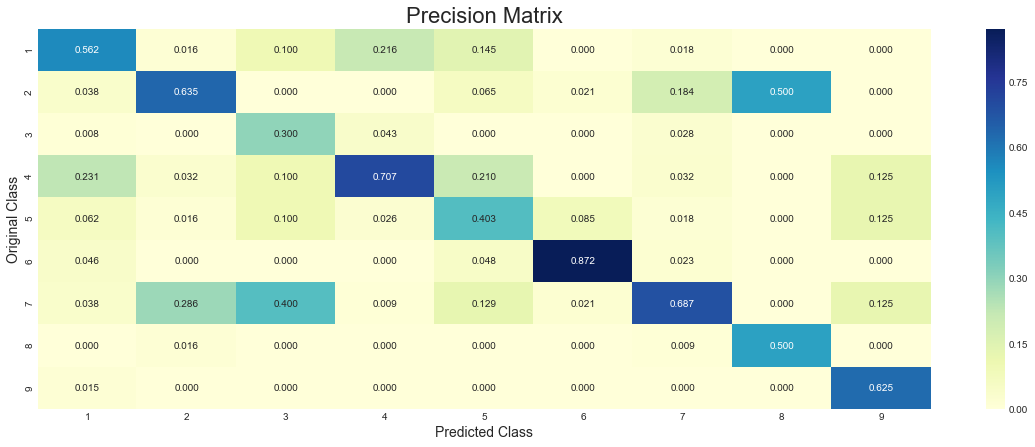

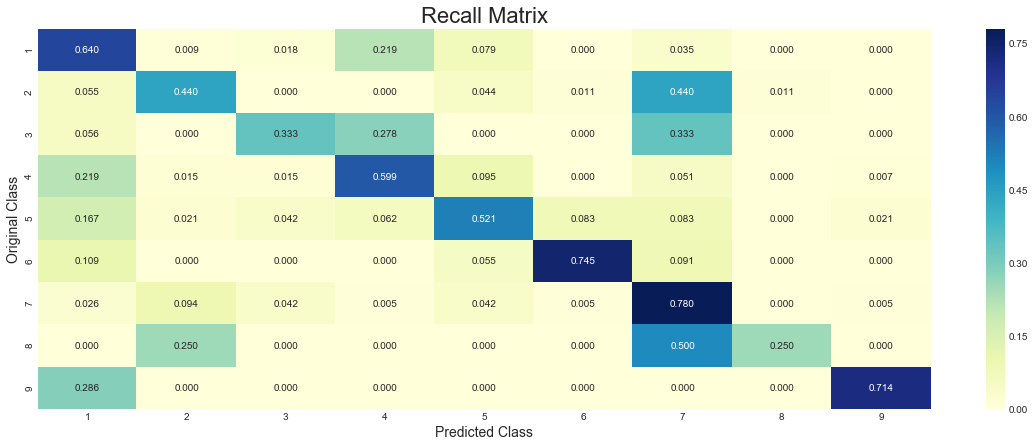

In [ ]:
plot_matrix(y_test, y_pred)

### Correctly Classified Point

In [ ]:
test_point_index = 5
no_features = 100
pred_cls = y_pred[test_point_index]
indices = np.argsort(-clf_lr.coef_[pred_cls-1])[:no_features]
print('Predicted Class :',pred_cls)
print('Predicted Class Probabilities :',\
      np.round(sig_clf_lr.predict_proba(X_test[test_point_index]),3))
print('Actual Class : ',y_test.iloc[test_point_index])
print('-'*100)
imp_features(indices,no_features,\
     X_test_df['Gene'].iloc[test_point_index],\
     X_test_df['Variation'].iloc[test_point_index],\
     X_test_df['Text'].iloc[test_point_index])

Predicted Class : 7
Predicted Class Probabilities : [[0.017 0.382 0.002 0.004 0.006 0.003 0.585 0.001 0.001]]
Actual Class :  7
----------------------------------------------------------------------------------------------------
1) Text 'activate' is present in query point
2) Text 'downstream' is present in query point
3) Text 'activation' is present in query point
8) Text 'oncogene' is present in query point
12) Text 'tyrosine' is present in query point
14) Text 'serum' is present in query point
24) Text 'nf' is present in query point
26) Text 'kinase' is present in query point
33) Text 'murine' is present in query point
34) Text 'overarch' is present in query point
36) Text 'mapk' is present in query point
38) Text 'refractory' is present in query point
39) Text 'akt' is present in query point
46) Text 'transformation' is present in query point
49) Text 'signaling' is present in query point
57) Text 'papillary' is present in query point
59) Text 'oncogenic' is present in query point


### Misclassified Point

In [ ]:
test_point_index = 2
no_features = 100
pred_cls = y_pred[test_point_index]
indices = np.argsort(-clf_lr.coef_[pred_cls-1])[:no_features]
print('Predicted Class :',pred_cls)
print('Predicted Class Probabilities :', np.round(sig_clf_lr.predict_proba(X_test[test_point_index]),3))
print('Actual Class : ',y_test.iloc[test_point_index])
print('-'*100)
imp_features(indices,no_features,\
     X_test_df['Gene'].iloc[test_point_index],\
     X_test_df['Variation'].iloc[test_point_index],\
     X_test_df['Text'].iloc[test_point_index])

Predicted Class : 5
Predicted Class Probabilities : [[0.091 0.002 0.002 0.389 0.501 0.014 0.    0.    0.   ]]
Actual Class :  4
----------------------------------------------------------------------------------------------------
Out of top 100 important features, 0 are present in query point


## Support Vector Machine

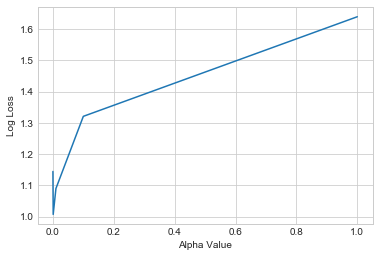

In [ ]:
alpha = [10**i for i in range(-4,1)]
cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(alpha = i, class_weight = 'balanced', loss = 'hinge', max_iter = 20)
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf,'sigmoid')
    sig_clf.fit(X_train, y_train)
    y_pred = sig_clf.predict_proba(X_cv)
    cv_log_loss.append(log_loss(y_cv, y_pred))

plt.plot(alpha, cv_log_loss)
plt.xlabel('Alpha Value')
plt.ylabel('Log Loss')
plt.show()

In [ ]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf_svc = SGDClassifier(alpha = best_alpha, class_weight = 'balanced', loss = 'hinge',\
                        max_iter = 100)
clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)
sig_clf_svc = CalibratedClassifierCV(clf_svc, method = 'sigmoid')
sig_clf_svc.fit(X_train, y_train)

loss_svc = [log_loss(y_train,sig_clf_svc.predict_proba(X_train)),\
            log_loss(y_cv,sig_clf_svc.predict_proba(X_cv)),\
            log_loss(y_test,sig_clf_svc.predict_proba(X_test))]

print('For alpha = {}, the log losses for various sets are'.format(best_alpha))
pd.DataFrame({'Set':['Train','Cross Validation','Test'],'Log Loss': loss_svc} ,\
             index = range(1,4))

For alpha = 0.001, the log losses for various sets are


,Set,Log Loss
1,Train,0.575167
2,Cross Validation,1.005803
3,Test,1.052102


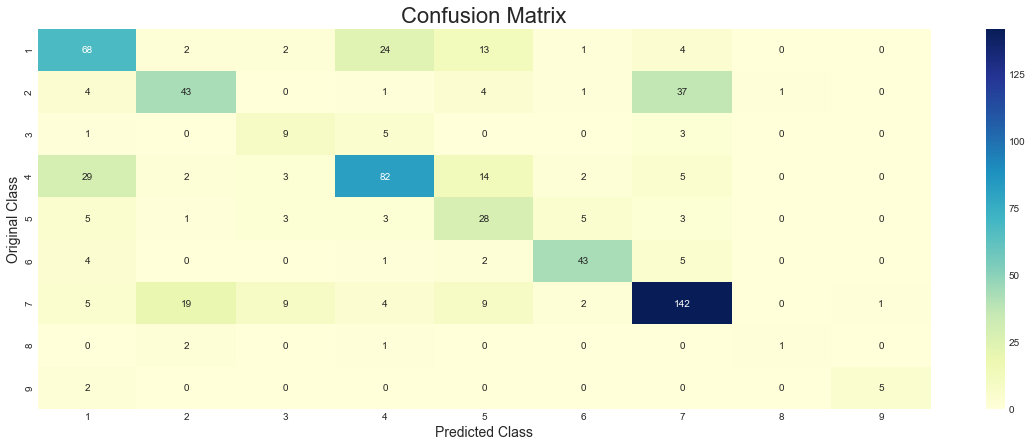

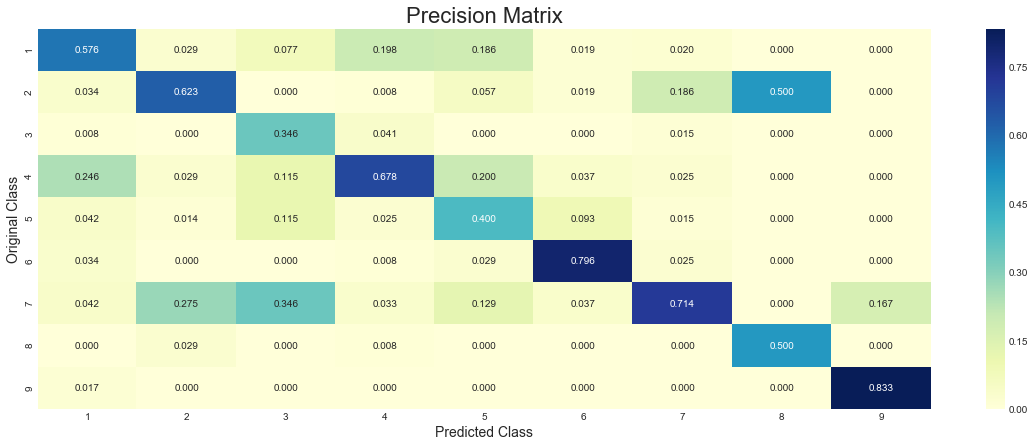

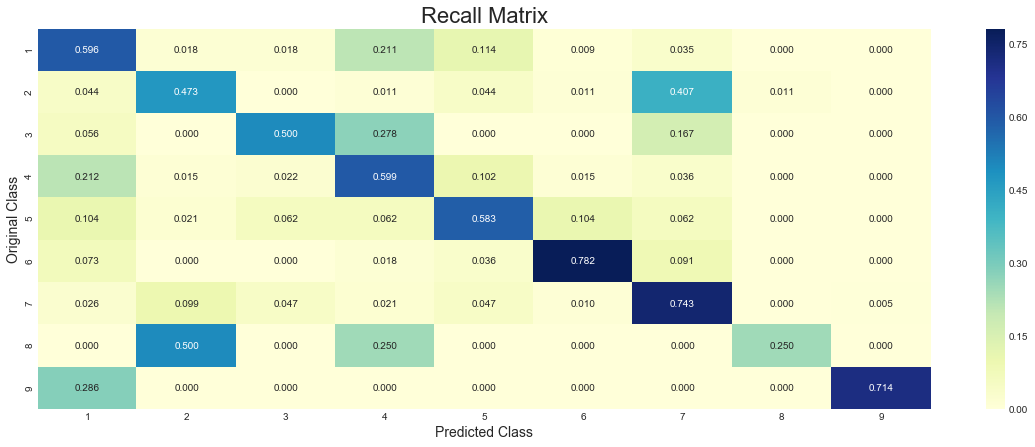

In [ ]:
plot_matrix(y_test, y_pred)

### Correctly Classified Point

In [ ]:
test_point_index = 5
no_features = 100
pred_cls = y_pred[test_point_index]
print('Predicted Class :', pred_cls)
print('Predicted Class Probabilities:', \
      np.round(sig_clf_svc.predict_proba(X_test[test_point_index]),4))
print('Actual Class :', y_test.iloc[test_point_index])
indices = np.argsort(-clf_svc.coef_[pred_cls-1])[:no_features]
print('-'*50)
imp_features(indices, no_features,\
     X_test_df['Gene'].iloc[test_point_index],\
     X_test_df['Variation'].iloc[test_point_index],\
     X_test_df['Text'].iloc[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.0499 0.2612 0.0052 0.0184 0.0194 0.0108 0.6302 0.0021 0.0028]]
Actual Class : 7
--------------------------------------------------
10) Text 'overarch' is present in query point
15) Text 'activate' is present in query point
24) Text 'activation' is present in query point
30) Text 'downstream' is present in query point
37) Text 'nf' is present in query point
Out of top 100 important features, 5 are present in query point


### Misclassified Point

In [ ]:
test_point_index = 2
no_features = 100
pred_cls = y_pred[test_point_index]
print('Predicted Class :', pred_cls)
print('Predicted Class Probabilities:', \
      np.round(sig_clf_svc.predict_proba(X_test[test_point_index]),4))
print('Actual Class :', y_test.iloc[test_point_index])
indices = np.argsort(-clf_svc.coef_[pred_cls-1])[:no_features]
print('-'*50)
imp_features(indices, no_features,\
     X_test_df['Gene'].iloc[test_point_index],\
     X_test_df['Variation'].iloc[test_point_index],\
     X_test_df['Text'].iloc[test_point_index])

Predicted Class : 5
Predicted Class Probabilities: [[0.0402 0.0433 0.0086 0.374  0.4418 0.0187 0.0647 0.0032 0.0056]]
Actual Class : 4
--------------------------------------------------
Out of top 100 important features, 0 are present in query point


## K Nearest Neighbors

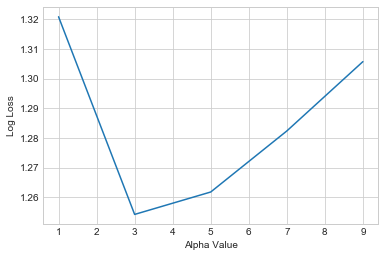

In [ ]:
alpha = [1,3,5,7,9]
cv_log_loss = []
for i in alpha:
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf,'sigmoid')
    sig_clf.fit(X_train, y_train)
    y_pred = sig_clf.predict_proba(X_cv)
    cv_log_loss.append(log_loss(y_cv, y_pred))

plt.plot(alpha, cv_log_loss)
plt.xlabel('Alpha Value')
plt.ylabel('Log Loss')
plt.show()

In [ ]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf_knn = KNeighborsClassifier(n_neighbors = best_alpha)
clf_knn.fit(X_train, y_train)
y_pred = clf_knn.predict(X_test)
sig_clf_knn = CalibratedClassifierCV(clf_knn, method = 'sigmoid')
sig_clf_knn.fit(X_train, y_train)

loss_knn = [log_loss(y_train,sig_clf_knn.predict_proba(X_train)),\
            log_loss(y_cv,sig_clf_knn.predict_proba(X_cv)),\
            log_loss(y_test,sig_clf_knn.predict_proba(X_test))]

print('For K = {}, the log losses for various sets are'.format(best_alpha))
pd.DataFrame({'Set':['Train','Cross Validation','Test'],'Log Loss': loss_knn} , \
             index = range(1,4))

For K = 3, the log losses for various sets are


,Set,Log Loss
1,Train,0.935974
2,Cross Validation,1.254217
3,Test,1.267394


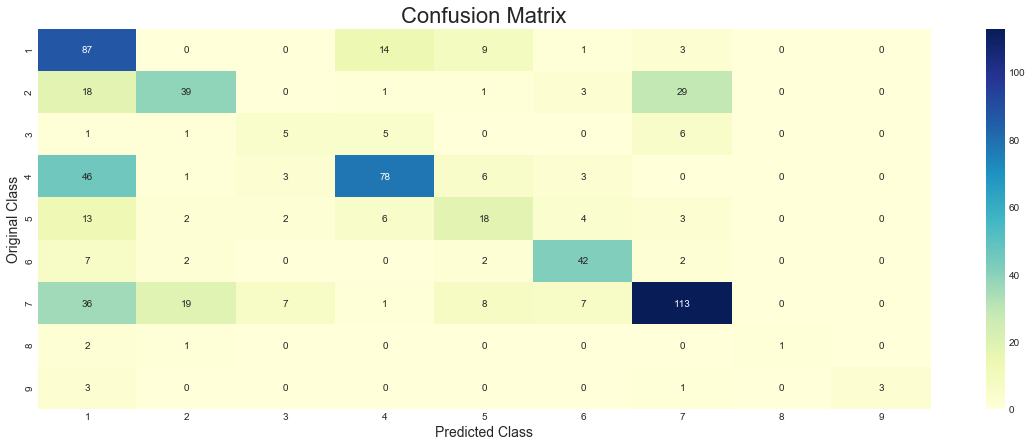

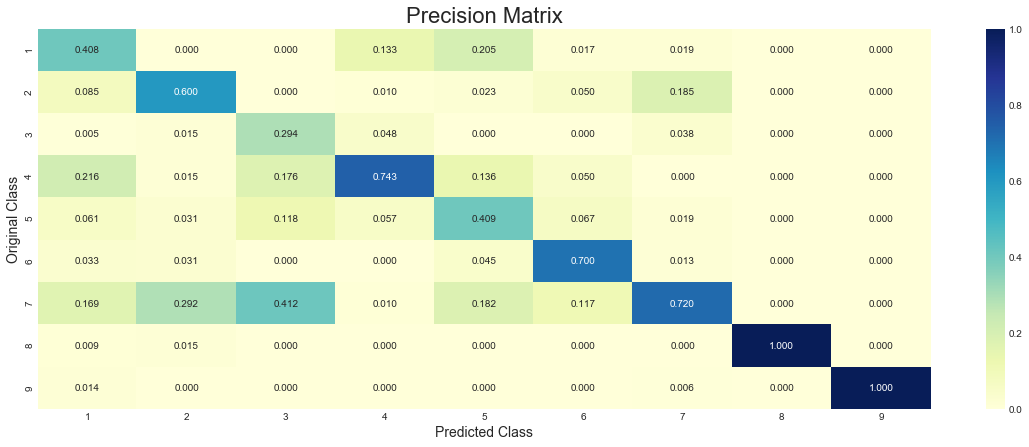

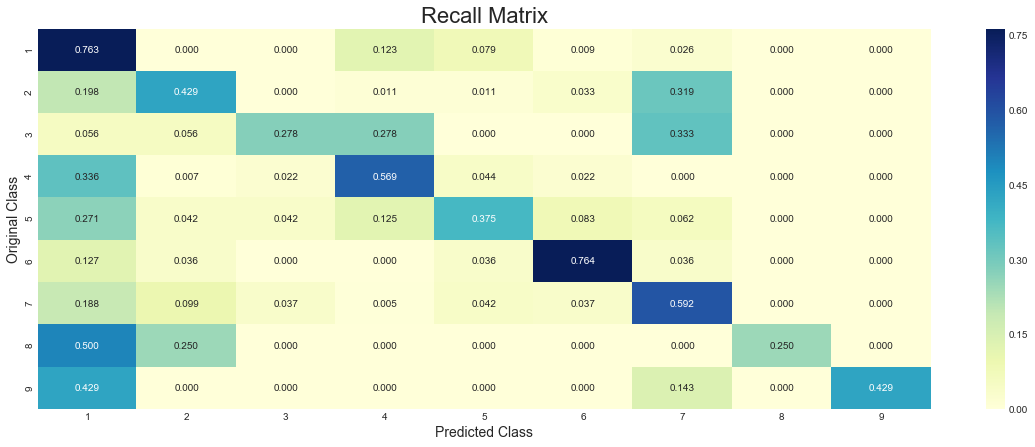

In [ ]:
plot_matrix(y_test,y_pred)

### Correctly Classified Point

In [ ]:
index = 1
pred_cls = y_pred[index]
print('Predicted Class :', pred_cls)
neighbors = clf_knn.kneighbors(X_test[index])[1].reshape(best_alpha,)
print('The {} nearest neighbours of the test point belongs to classes {}'.\
      format(best_alpha,y_train.iloc[neighbors].values))
print('Actual Class :', y_test.iloc[index])
Counter(y_train.iloc[neighbors].values)

Predicted Class : 6
The 3 nearest neighbours of the test point belongs to classes [6 6 6]
Actual Class : 6


Counter({6: 3})

### Misclassified Point

In [ ]:
test_point_index = 2
pred_cls = y_pred[test_point_index]
print('Predicted Class :', pred_cls)
neighbors = clf_knn.kneighbors(X_test[test_point_index])[1].reshape(best_alpha,)
print('The {} nearest neighbours of the test point belongs to classes {}'.\
      format(best_alpha,y_train.iloc[neighbors].values))
print('Actual Class :', y_test.iloc[test_point_index])
Counter(y_train.iloc[neighbors].values)

Predicted Class : 5
The 3 nearest neighbours of the test point belongs to classes [5 4 5]
Actual Class : 4


Counter({4: 1, 5: 2})

## Random Forest Classifier

In [ ]:
alpha = [20,40,60,80,100]
max_depth = [10,20,40]
cv_log_loss = []
for i in alpha:
    cv_log_loss1 = []
    for j in max_depth :
        clf = RandomForestClassifier(n_estimators = i, max_depth = j, \
                                     class_weight = 'balanced')
        clf.fit(X_train,y_train)
        sig_clf = CalibratedClassifierCV(clf,'sigmoid')
        sig_clf.fit(X_train, y_train)
        y_pred = sig_clf.predict_proba(X_cv)
        cv_log_loss1.append(log_loss(y_cv, y_pred))
    cv_log_loss.append(cv_log_loss1)

In [ ]:
min_loss_ind = np.where(cv_log_loss == np.min(cv_log_loss))
min_loss_ind = tuple(i.item() for i in min_loss_ind)
best_alpha = alpha[min_loss_ind[0]]
best_depth = max_depth[min_loss_ind[1]]

clf_rf = RandomForestClassifier(n_estimators = best_alpha, max_depth = best_depth,\
                                class_weight = 'balanced')
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
sig_clf_rf = CalibratedClassifierCV(clf_rf, method = 'sigmoid')
sig_clf_rf.fit(X_train, y_train)

loss_rf = [log_loss(y_train,sig_clf_rf.predict_proba(X_train)),\
           log_loss(y_cv,sig_clf_rf.predict_proba(X_cv)),\
           log_loss(y_test,sig_clf_rf.predict_proba(X_test))]

print('For n_estimators = {}, max_depth = {}, the log losses for various sets are'.\
      format(best_alpha, best_depth))
pd.DataFrame({'Set':['Train','Cross Validation','Test'],'Log Loss': loss_rf} , \
             index = range(1,4))

For n_estimators = 100, max_depth = 20, the log losses for various sets are


,Set,Log Loss
1,Train,0.542657
2,Cross Validation,1.166653
3,Test,1.168934


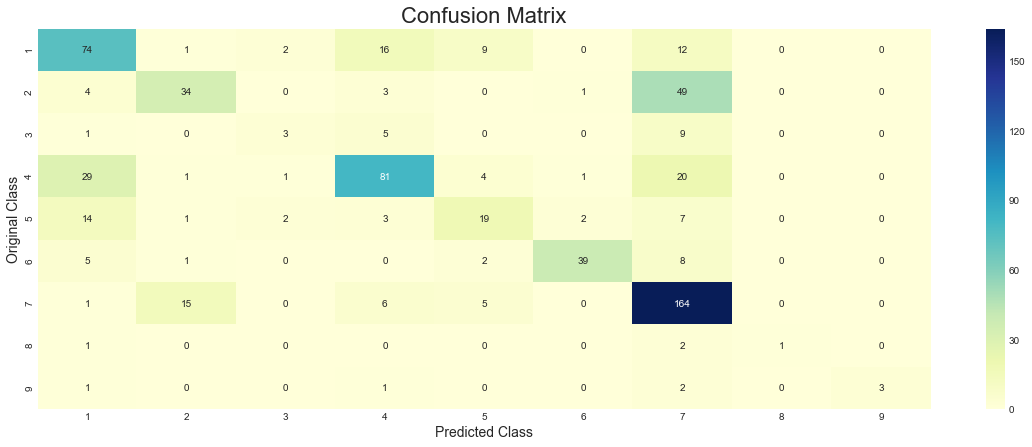

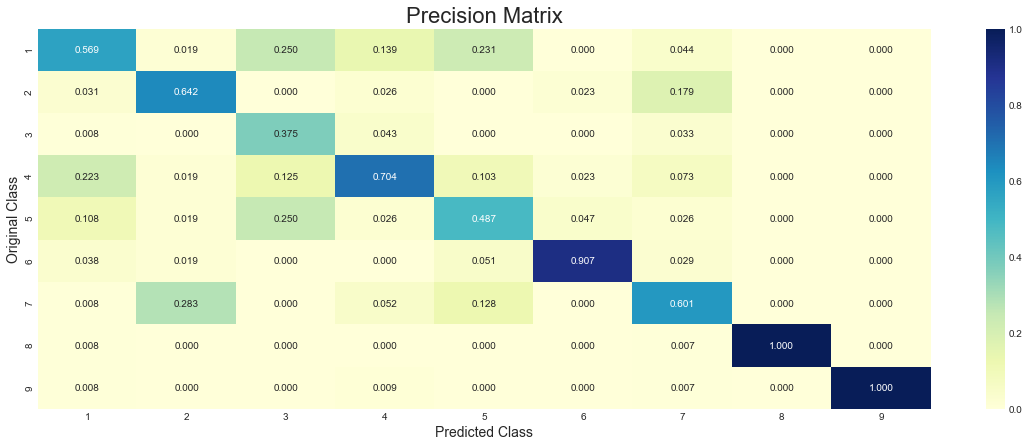

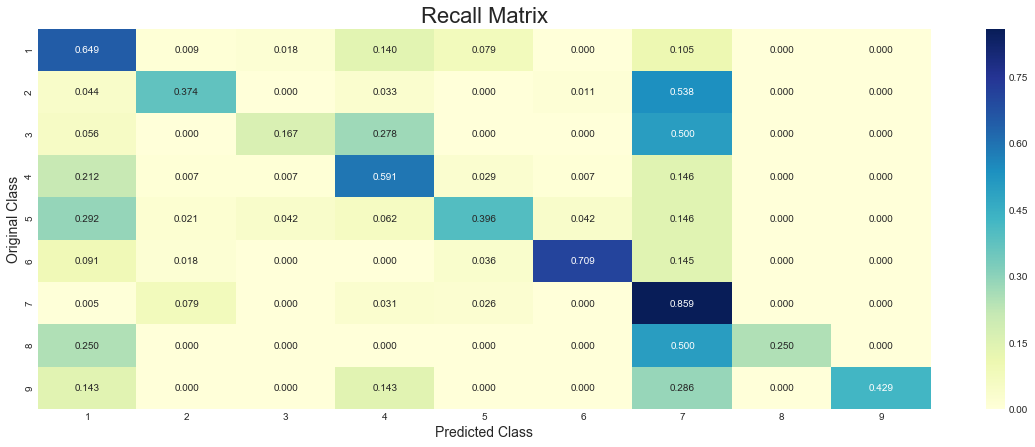

In [ ]:
plot_matrix(y_test,y_pred)

## Stacking Classifier

In [ ]:
alpha = [0.0001,0.001,0.01,0.1,1,10] 
cv_log_loss = []
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers = [sig_clf_rf, sig_clf_lr, sig_clf_svc],\
                              meta_classifier = lr, use_probas = True)
    sclf.fit(X_train, y_train)
    y_pred = sclf.predict_proba(X_cv)
    cv_log_loss.append(log_loss(y_cv, y_pred))

In [ ]:
best_alpha = alpha[np.argmin(cv_log_loss)]
lr = LogisticRegression(C=best_alpha)
sclf = StackingClassifier(classifiers = [sig_clf_rf, sig_clf_lr, sig_clf_svc],\
                          meta_classifier = lr, use_probas = True)
sclf.fit(X_train, y_train)
y_pred = sclf.predict(X_test)


loss_sclf = [log_loss(y_train,sclf.predict_proba(X_train)),\
             log_loss(y_cv,sclf.predict_proba(X_cv)),\
             log_loss(y_test,sclf.predict_proba(X_test))]

print('For alpha = {}, the log losses for various sets are'.format(best_alpha))
pd.DataFrame({'Set':['Train','Cross Validation','Test'],'Log Loss': loss_sclf} , \
             index = range(1,4))

For alpha = 0.1, the log losses for various sets are


,Set,Log Loss
1,Train,0.424818
2,Cross Validation,1.029636
3,Test,1.076675


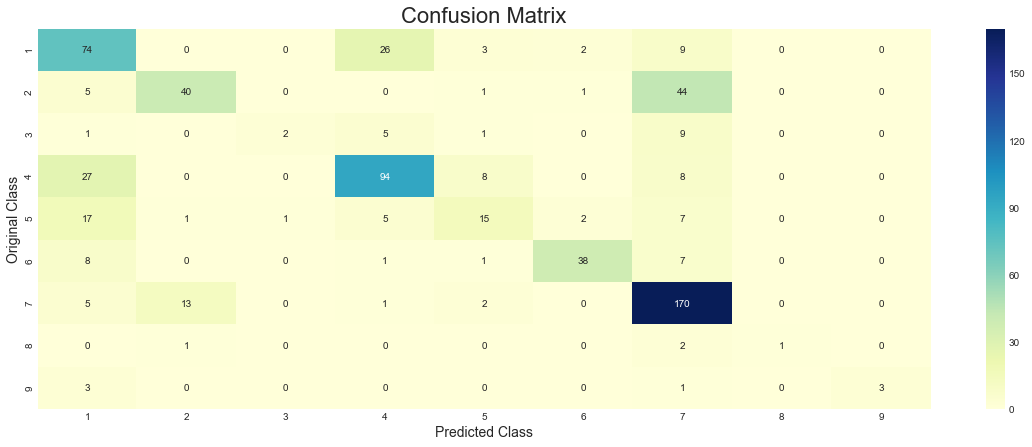

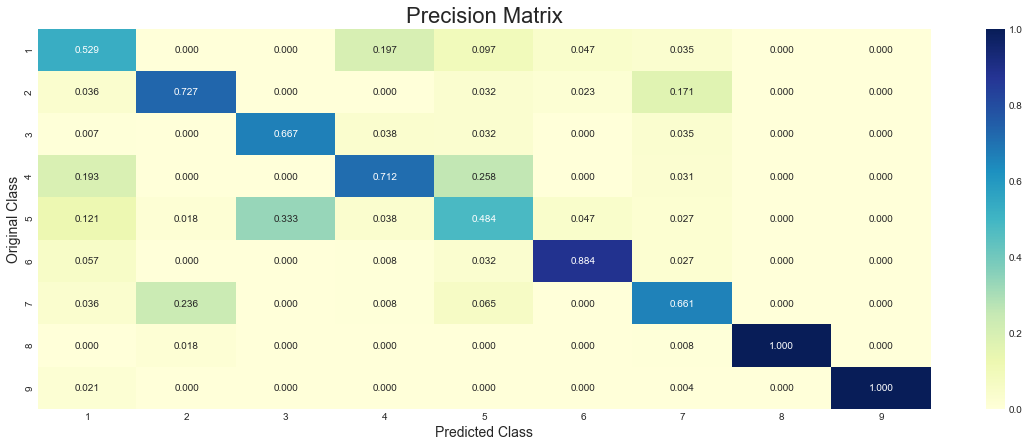

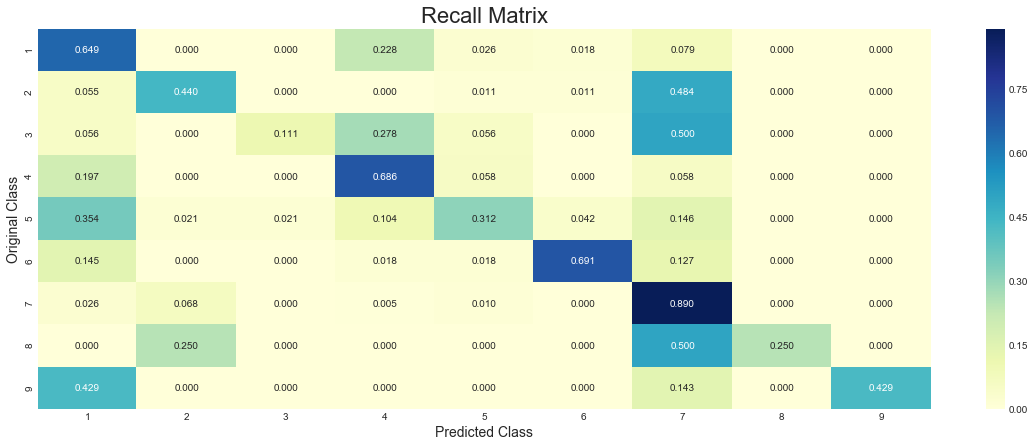

In [ ]:
plot_matrix(y_test,y_pred)

## Maximum Voting Classifier

In [ ]:
vclf = VotingClassifier(estimators=[('lr', sig_clf_lr), ('svc', sig_clf_svc), \
                                    ('rf', sig_clf_rf)], voting='soft')
vclf.fit(X_train, y_train)
y_pred = vclf.predict(X_test)

loss_vclf = [log_loss(y_train,vclf.predict_proba(X_train)),\
             log_loss(y_cv,vclf.predict_proba(X_cv)),\
             log_loss(y_test,vclf.predict_proba(X_test))]

pd.DataFrame({'Set':['Train','Cross Validation','Test'],'Log Loss': loss_vclf} , \
             index = range(1,4))

,Set,Log Loss
1,Train,0.556476
2,Cross Validation,0.983606
3,Test,1.029845


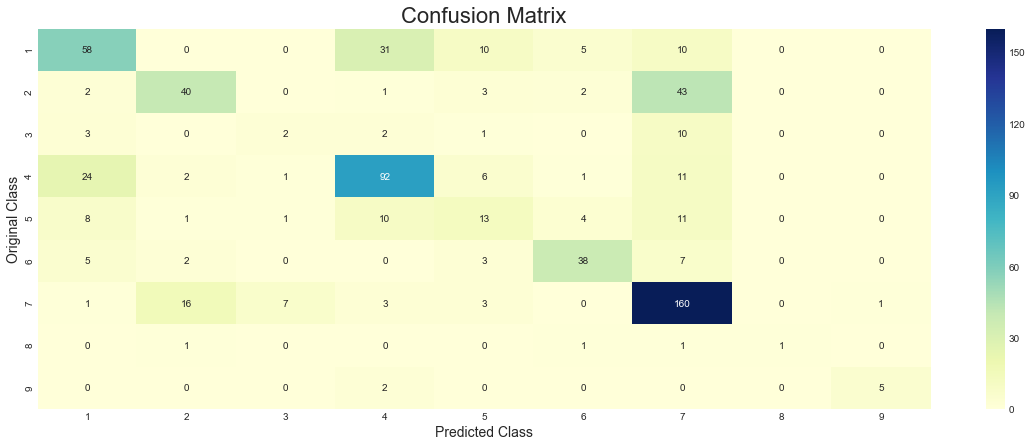

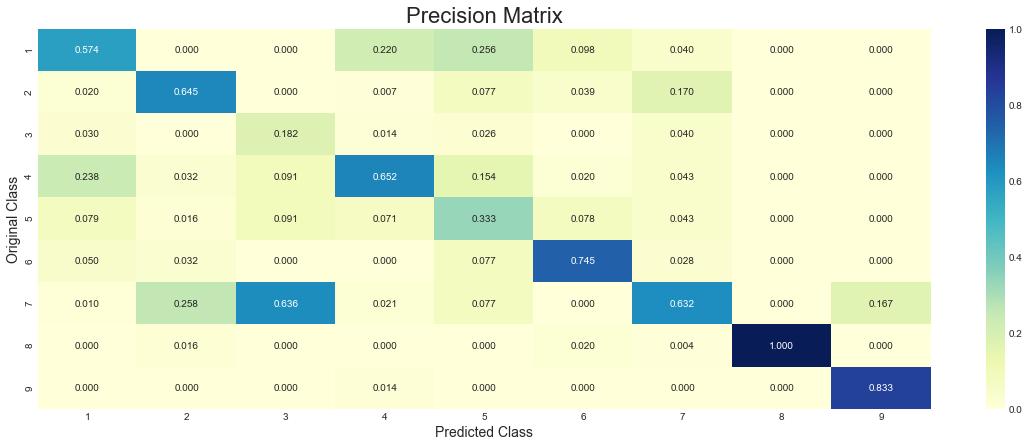

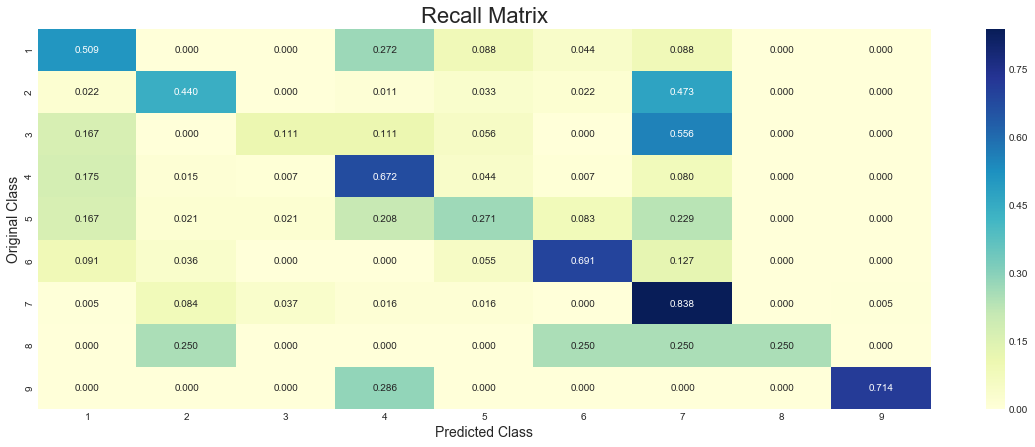

In [ ]:
plot_matrix(y_test,y_pred)

# Result

In [ ]:
pd.DataFrame({'Multinomial NB':loss_nb,'Logistic Regression':loss_lr,\
              'Support Vector Classifier':loss_svc,'K Neighbors':loss_knn,\
              'Random Forest Classifier':loss_rf,\
              'Stacking Classifier':loss_sclf,'Voting Classifier':loss_vclf},\
             index = ['Train Set','CV Set','Test Set'])

,Multinomial NB,Logistic Regression,Support Vector Classifier,K Neighbors,Random Forest Classifier,Stacking Classifier,Voting Classifier
Train Set,0.876146,0.574532,0.575167,0.935974,0.542657,0.424818,0.556476
CV Set,1.209692,0.979364,1.005803,1.254217,1.166653,1.029636,0.983606
Test Set,1.237686,1.049650,1.052102,1.267394,1.168934,1.076675,1.029845
